# Ensemble Learning Exercise

## 1. Implementing Random Forest From Scratch (30 points)
In this exercise you will need to implement a simple version of Random Forest Regressor from scratch. Your model will handle **continuous input and output**. 

1.1. Compelete the skeleton class below (you should use scikit-learn's `DecisionTreeRegressor` model that the `TreeEnsemble` will use)
- 'X' is a matrix of data values (rows are samples, columns are attributes)
- `y` is a vector of corresponding target values
- `n_trees` is the number of trees to create
- `sample_sz` is the size of the sample set to use of each of the trees in the forest (chose the samples randomly, with or without repetition)
- `n_features` is the size of features to sample. This can be a natrual number > 0, or a ratio of the features as a number in range (0,1]
- `min_leaf` is the minimal number of samples in each leaf node of each tree in the forest
  

1.2. The `predict` function will use mean of the target values of the trees. The result is a vector of predictions matching the number of rows in `X`.

1.3. The `oob_mse` function will compute the mean squared error over all **out of bag (oob)** samples. That is, for each sample calculate the squared error using  predictions from the trees that do not contain x in their respective bootstrap sample, then average this score for all samples. See:  [OOB Errors for Random Forests](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html).

1.4. To check your random forest implementation, use the boston dataset (`from sklearn.datasets import load_boston`)

  - Use the following to estimate what are the best hyper parameters to use for your model
```
for n in [1,5,10,20,50,100]:
  for sz in [50,100,300,500]:
    for min_leaf in [1,5]:
      forest = TreeEnsemble(X, y, n, sz, min_leaf)
      mse = forest.oob_mse()
      print("n_trees:{0}, sz:{1}, min_leaf:{2} --- oob mse: {3}".format(n, sz, min_leaf, mse))
```
  
  - Using your chosen hyperparameters as a final model, plot the predictions vs. true values of all the samples in the training set . Use something like:
  ```
  y_hat = forest.predict(X)  # forest is the chosen model
  plt.scatter(y_hat, y)
  ```
 


## Load data and import stuff

In [106]:
from sklearn.datasets import load_boston
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load the Boston Housing dataset
boston = load_boston()

# Convert the dataset to a DataFrame
X = boston.data

# Add the target variable (median value of the houses) to the DataFrame
y = boston.target

## IMPLEMENT FOREST

In [107]:

class TreeEnsemble():
    def __init__(self, X, y, n_trees, sample_sz, n_features, min_leaf):
        self.samples = X
        self.targets = y
        self.n_trees = n_trees 
        self.sample_sz =  sample_sz
        if isinstance(n_features,float): ## converts percentage to number of features
            self.n_features =  int(n_features *  X.shape[1])
        else:
            self.n_features = n_features
        self.min_leaf = min_leaf
        self.trees = [] # List holding all the trees.
        self.oob_scores = np.zeros(shape=(2,X.shape[0])) # List holding OOB score for each tree, used to calculate oob_mse.
        self.cols = []
        self.create_trees()
        


    def create_trees(self):
        
        for i in range(self.n_trees): # loop creating n_trees
            
            # partition data by rows and features (in bag data)
            ib_X,ib_y,oob_X,oob_y,indx = self.bootstrap() # ib = in_bag

            # generate tree
            tree = DecisionTreeRegressor(random_state = i ,min_samples_leaf=self.min_leaf,max_features = self.n_features) 
            tree.fit(ib_X, ib_y) 
            self.trees.append(tree)
            
            # calculate oob_error and append oob_scores list
            self.oob_scores[0,indx] += tree.predict(oob_X)
            self.oob_scores[1,indx] += 1


        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            self.oob_scores = self.oob_scores[0,:] / self.oob_scores[1,:]

        
    def bootstrap(self):
        rows = np.random.choice(self.samples.shape[0], self.sample_sz, replace=False)
        oob_idx = np.setdiff1d(np.arange(self.samples.shape[0]), rows)
        cols = np.random.choice(self.samples.shape[1], self.n_features, replace=False)
        ib_y = self.targets[rows]
        ib_X = self.samples[rows, :][:, cols]
        oob_X = self.samples[oob_idx, :][:, cols]
        oob_y = self.targets[oob_idx]
        self.cols.append(cols)
        return ib_X, ib_y, oob_X, oob_y,oob_idx

 
    def oob_mse(self):
        return np.mean((self.oob_scores - self.targets)**2)

    def predict(self, X):    
        y_pred = []
        for row in X:
            pred = []
            for i in range(self.n_trees):
                relev_row = row[self.cols[i]]
                pred.append( self.trees[i].predict(relev_row.reshape(1,-1)))
            y_pred.append(np.mean(pred))
        return y_pred

In [108]:
best_mse = np.inf
best_hyper = []

for n in [1,5,10,20,50,100]:
  for sz in [50,100,300,500]:
    for n_features in [3,5,10]:
      for min_leaf in [1,5]:
        forest = TreeEnsemble(X, y, n, sz, n_features,min_leaf)
        mse = forest.oob_mse()        
        if best_mse > mse:
          best_mse = mse
          best_hyper = [n,sz,n_features,min_leaf]

print(best_hyper)
print(best_mse)


[100, 300, 10, 1]
12.212713083607923


1.8562689367588936


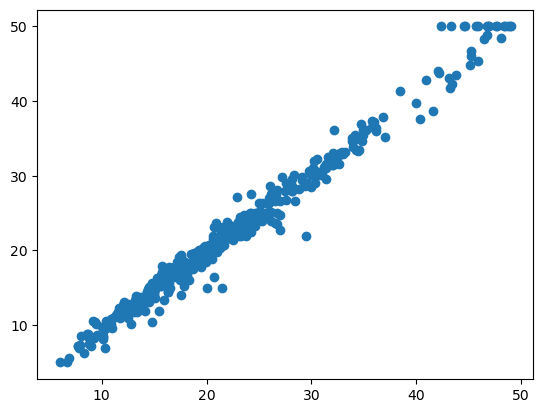

In [109]:
forest = TreeEnsemble(X,y,*best_hyper)
y_hat = forest.predict(X)  # forest is the chosen model
plt.scatter(y_hat, y)
print(np.mean((y_hat - y)**2))

## FOREST WITH NP

## 2. Implementing AdaBoost From Scratch (30 points)


2.1.   Implement the AdaBoost algorithm for classification task. Your `AdaBoost` class should receive a method for creating a weak learner, which has a fit and predict methods (simulate re-weighting of the samples by an appropriate re-sampling of the train set).

2.2.   Use your model to find a strong classifier on the sample set given below, using $n$ weak learners:

2.2.1. For the base weak learners, use any classifier you want (check different types with different configuration, keep them simple = Weak). 

2.2.2. Split the sample set into train and test sets.

2.2.3 Plot the final decision plane of your classifier for $n\in \{1, 2, 3, 5, 10, 50\}$, and visualize the final iteration weights of the samples in those plots.
    - How does the overall train set accuracy changes with $n$?
    - Does you model starts to overfit at some point?





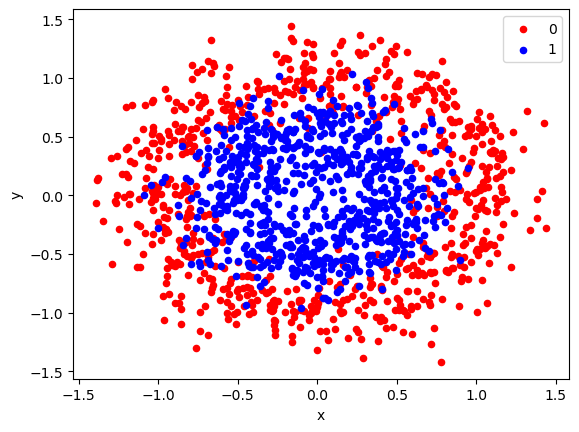

In [92]:
from sklearn.datasets import make_circles
from matplotlib import pyplot
from pandas import DataFrame

# generate 2d classification dataset
X, y = make_circles(n_samples=1500, noise=0.2, random_state=101, factor=0.5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train = np.where(y_train==0,-1,1) # our classifier needs 1 and -1 values
y_test = np.where(y_test==0,-1,1) # our classifier needs 1 and -1 values
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()


In [93]:
class AdaBoost:
    def __init__(self,model, n_learners,hyper_params=[]):
        self.model = model
        self.hyper_params = hyper_params
        self.n_learners = n_learners
        self.alphas = []
        self.learners = []
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        w = np.ones(n_samples) / n_samples

        for i in range(self.n_learners):
            learner = self.model(**self.hyper_params)
            learner.fit(X , y,sample_weight=w)
            y_pred = learner.predict(X)
            e = np.sum(w[y != y_pred])
            alpha = 0.5 * np.log((1 - e) / e)
            w *= np.exp(-alpha * y * y_pred)
            w /= np.sum(w)
            self.alphas.append(alpha)
            self.learners.append(learner)

    def predict(self, X):
        n_samples = X.shape[0]
        y_pred = np.zeros(n_samples)
        for alpha, learner in zip(self.alphas, self.learners):
            y_pred += alpha * learner.predict(X)
        return np.sign(y_pred)


    

In [102]:
best_accuracy = 0
best_n = 0
for n in [1,2,3,5,10,50,100]:
    model = AdaBoost(DecisionTreeClassifier,n_learners=n,hyper_params={'max_depth':1})
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = np.mean(y_pred == y_test)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_n = n
print(best_accuracy)

0.88


In [95]:

for n in [1,2,3,5,10,50]:
    model = AdaBoost(DecisionTreeClassifier,n_learners=n,hyper_params={'max_depth':1})
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = np.mean(y_pred == y_test)



In [96]:
best_boost = AdaBoost(DecisionTreeClassifier,n_learners=best_n,hyper_params={'max_depth':1})

## 3. Boosting Trees from Scratch (40 points)
1. Use the scikit-learn's DecisionTreeRegressor (again :) with `max_depth = 1` (stumps)  to write a L2Boost model which minimize the L2 square loss iteration by iteration.
Reminder: in each step, build a decision tree to minimize the error between the true label and the accumulated (sum) of the previous step predictions.
![alt text](https://explained.ai/gradient-boosting/images/latex-321A7951E78381FB73D2A6874916134D.svg)
2. Use the Boston dataset to plot the MSE as a function of the number of trees for a logspace of `n_trees` up to 1,000. What is the optimal value of `n_trees`? of learning rate?
3. Compare the performance with a deep DecisionTreeRegressor (find the optimal `max_depth`).  Who wins?
4. Add an early-stopping mechanisim to the GBTL2 model to use a validation set to detect over-fit.

In [228]:
from sklearn.preprocessing import StandardScaler
X = boston.data
y = boston.target
scaler = StandardScaler()
X = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [328]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np

class L2Boost:
    def __init__(self, n_estimators=50,learning_rate=0.1):
        self.n_estimators = n_estimators
        # self.max_depth = max_depth
        self.trees = []
        self.avg = 0
        self.learning_rate = learning_rate
    def fit(self, X, y):
        y_pred = np.ones_like(y) * y.mean()
        self.avg =  y.mean()
        for i in range(self.n_estimators):
                residual = y - y_pred
                tree = DecisionTreeRegressor(max_depth=1,random_state = i) # max_depth=self.max_depth
                tree.fit(X, residual)
                y_pred += self.learning_rate * tree.predict(X)
                self.trees.append(tree)

    def predict(self, X):
        y_pred = np.ones(X.shape[0]) * self.avg
        for tree in self.trees:
            y_pred += tree.predict(X)
        return y_pred


IndentationError: unexpected indent (1896770433.py, line 16)

In [111]:
np.logspace(0, 3, num=3, dtype=int)

array([   1,   31, 1000])

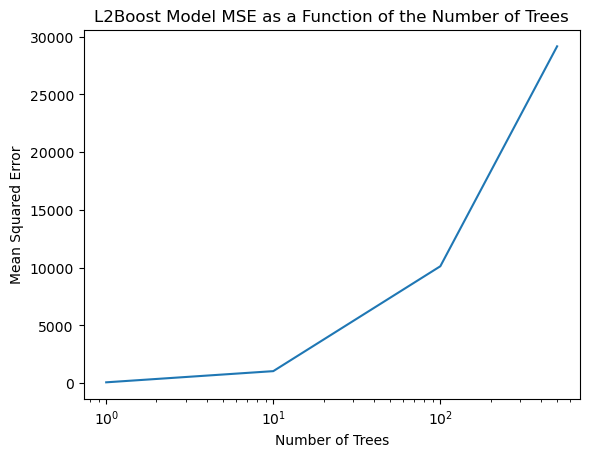

In [327]:
model = L2Boost(n_estimators=100,learning_rate=0.1)

# Generate a logspace of n_trees up to 1000
n_trees = np.logspace(0, 3, num=10, dtype=int)

# Store the MSE for each number of trees
mse = []
for n in [1,10,100,500]:
    model.n_estimators = n
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse.append(((y_test - y_pred)**2).mean())

# Plot the MSE as a function of the number of trees
plt.plot([1,10,100,500], mse)
plt.xscale('log')
plt.xlabel('Number of Trees')
plt.ylabel('Mean Squared Error')
plt.title('L2Boost Model MSE as a Function of the Number of Trees')
plt.show()

5237.758422576182
10.747180683038664


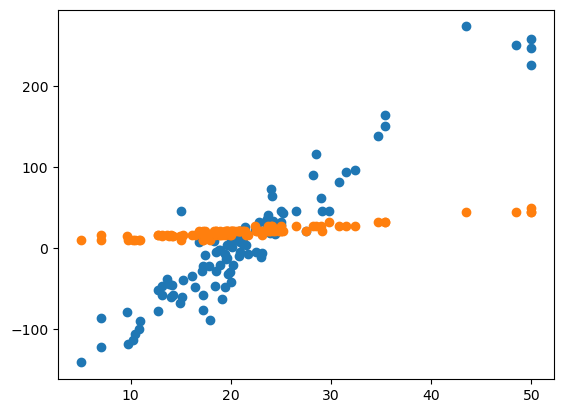

In [237]:
model = L2Boost(n_estimators=100,learning_rate=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
plt.scatter(y_test,y_pred)
print( ((y_pred - y_test)**2).mean())



model = L2Boost(n_estimators=1,learning_rate=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
plt.scatter(y_test,y_pred)
print( ((y_pred - y_test)**2).mean())